Loading datasets...
Datasets loaded successfully

Testing Pseudoinverse Autoencoder:

Pseudoinverse Autoencoder Parameters:
Encoder parameters (only stored weights): 565,248
Decoder parameters: 0 (uses pseudoinverse of encoder weights)
Total unique parameters: 565,248

Pseudoinverse Autoencoder Architecture Explanation:
1. Weight Relationship:
   - Decoder weights are pseudoinverse of encoder weights
   - Uses Moore-Penrose pseudoinverse for better reconstruction
   - Handles cases where regular inverse might not exist

2. Activation Functions:
   - Encoder: LeakyReLU with slope 0.2
   - Decoder: Inverse LeakyReLU with slope 1/0.2 = 5
   - Maintains reconstruction capability through inverse functions

3. Advantages:
   - More stable than simple transpose for non-square matrices
   - Better reconstruction when encoder weights are not full rank
   - Minimizes reconstruction error in least squares sense

Training Pseudoinverse Autoencoder...
Using device: cpu
Epoch [1/40], Loss: 0.155187


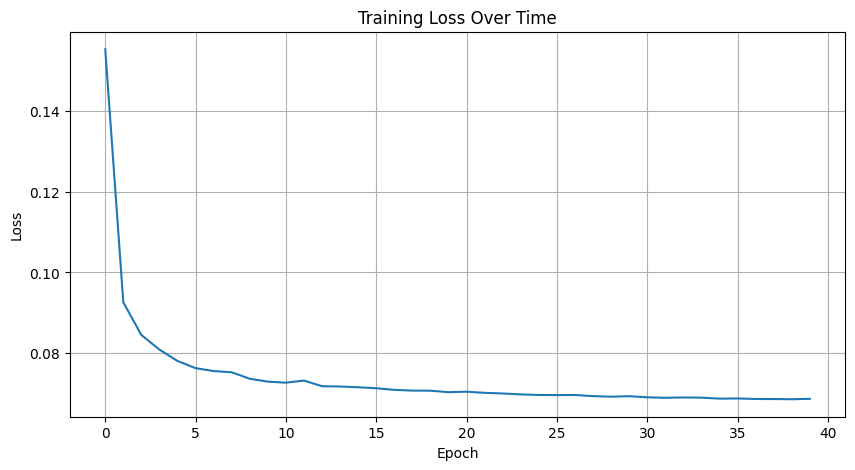

Generating visualizations...


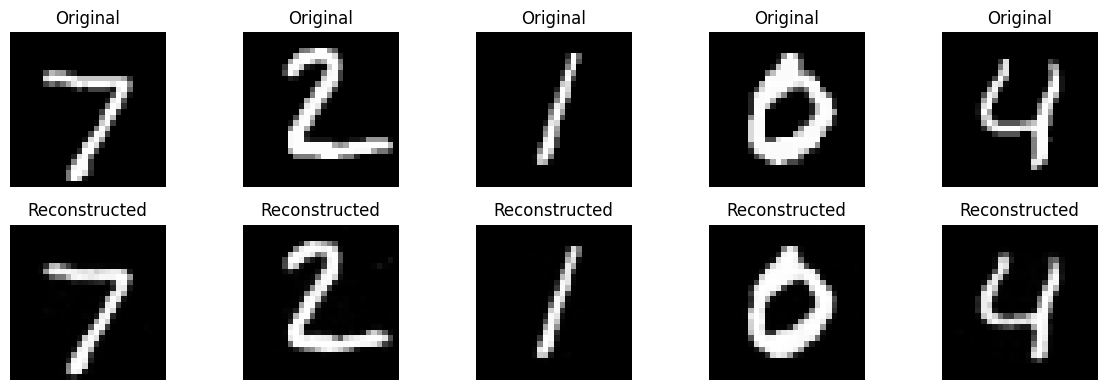

Training completed!


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
#from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Custom Dataset class for MNIST (same as before)
class MNISTDataset(Dataset):
    def __init__(self, csv_file):
        data = pd.read_csv(csv_file)
        self.labels = data.iloc[:, 0].values
        self.features = data.iloc[:, 1:].values
        self.features = self.features / 255.0
        self.features = self.features - np.mean(self.features, axis=0)
        min_vals = np.min(self.features, axis=0)
        max_vals = np.max(self.features, axis=0)
        self.features = (self.features - min_vals) / (max_vals - min_vals + 1e-8)
        self.features = torch.FloatTensor(self.features)
        self.labels = torch.LongTensor(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


# Pseudoinverse Autoencoder
class PseudoinverseAutoencoder(nn.Module):
    def __init__(self, input_size=784, latent_size=128):
        super(PseudoinverseAutoencoder, self).__init__()

        # Define intermediate layer sizes
        h1_size = 512  # First hidden layer
        h2_size = 256  # Second hidden layer

        # Encoder layers - only store encoder weights
        self.encoder_layer1 = nn.Linear(input_size, h1_size, bias=False)
        self.encoder_layer2 = nn.Linear(h1_size, h2_size, bias=False)
        self.encoder_layer3 = nn.Linear(h2_size, latent_size, bias=False)

        # Encoder activation functions
        self.encoder_activation = nn.LeakyReLU(negative_slope=0.2)

        # Decoder activation functions (inverse of LeakyReLU)
        self.decoder_activation = lambda x: torch.where(x < 0, x / 0.2, x)

        # Initialize weights
        nn.init.xavier_uniform_(self.encoder_layer1.weight)
        nn.init.xavier_uniform_(self.encoder_layer2.weight)
        nn.init.xavier_uniform_(self.encoder_layer3.weight)

    def forward(self, x):
        # Flatten input
        x = x.view(x.size(0), -1)

        # Encode
        e1 = self.encoder_activation(self.encoder_layer1(x))
        e2 = self.encoder_activation(self.encoder_layer2(e1))
        encoded = self.encoder_layer3(e2)

        # Decode using pseudoinverse weights
        # Note: pinverse is computationally expensive, in practice you might want to cache these
        d1 = self.decoder_activation(F.linear(encoded, torch.pinverse(self.encoder_layer3.weight)))
        d2 = self.decoder_activation(F.linear(d1, torch.pinverse(self.encoder_layer2.weight)))
        decoded = torch.sigmoid(F.linear(d2, torch.pinverse(self.encoder_layer1.weight)))

        return decoded

    def count_parameters(self):
        """Count the number of trainable parameters"""
        params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print("\nPseudoinverse Autoencoder Parameters:")
        print(f"Encoder parameters (only stored weights): {params:,}")
        print(f"Decoder parameters: 0 (uses pseudoinverse of encoder weights)")
        print(f"Total unique parameters: {params:,}")
        return params


def train_model(model, train_loader, num_epochs=40, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data, _ in train_loader:
            data = data.to(device)

            output = model(data)
            loss = criterion(output, data.view(data.size(0), -1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.6f}')

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()


def visualize_reconstructions(model, test_loader, num_images=5):
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data[:num_images].to(device)
        reconstructions = model(data)

        plt.figure(figsize=(12, 4))
        for i in range(num_images):
            plt.subplot(2, num_images, i + 1)
            plt.imshow(data[i].cpu().view(28, 28), cmap='gray')
            plt.title('Original')
            plt.axis('off')

            plt.subplot(2, num_images, i + num_images + 1)
            plt.imshow(reconstructions[i].cpu().view(28, 28), cmap='gray')
            plt.title('Reconstructed')
            plt.axis('off')

        plt.tight_layout()
        plt.show()


def explain_pseudoinverse_architecture():
    print("\nPseudoinverse Autoencoder Architecture Explanation:")
    print("1. Weight Relationship:")
    print("   - Decoder weights are pseudoinverse of encoder weights")
    print("   - Uses Moore-Penrose pseudoinverse for better reconstruction")
    print("   - Handles cases where regular inverse might not exist")

    print("\n2. Activation Functions:")
    print("   - Encoder: LeakyReLU with slope 0.2")
    print("   - Decoder: Inverse LeakyReLU with slope 1/0.2 = 5")
    print("   - Maintains reconstruction capability through inverse functions")

    print("\n3. Advantages:")
    print("   - More stable than simple transpose for non-square matrices")
    print("   - Better reconstruction when encoder weights are not full rank")
    print("   - Minimizes reconstruction error in least squares sense")


def main():
    # Hyperparameters
    BATCH_SIZE = 250
    LATENT_SIZE = 128
    NUM_EPOCHS = 40

    # Load datasets
    print("Loading datasets...")
    train_dataset = MNISTDataset('mnist_train.csv')
    test_dataset = MNISTDataset('mnist_test.csv')

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print("Datasets loaded successfully")

    # Initialize and test pseudoinverse autoencoder
    print("\nTesting Pseudoinverse Autoencoder:")
    model = PseudoinverseAutoencoder(input_size=784, latent_size=LATENT_SIZE)
    model.count_parameters()

    explain_pseudoinverse_architecture()

    # Train the model
    print("\nTraining Pseudoinverse Autoencoder...")
    train_model(model, train_loader, NUM_EPOCHS)

    # Visualize results
    print("Generating visualizations...")
    visualize_reconstructions(model, test_loader)

    print("Training completed!")


if __name__ == "__main__":
    main()